*Unit 2, Sprint 3, Module 3*

---

# Permutation & Boosting

- Get **permutation importances** for model interpretation and feature selection
- Use xgboost for **gradient boosting**

### Setup

Run the code cell below. You can work locally (follow the [local setup instructions](https://lambdaschool.github.io/ds/unit2/local/)) or on Colab.

Libraries:

- category_encoders
- [**eli5**](https://eli5.readthedocs.io/en/latest/)
- matplotlib
- numpy
- pandas
- scikit-learn
- [**xgboost**](https://xgboost.readthedocs.io/en/latest/)

In [2]:
?%%capture

Docstring:
::

  %capture [--no-stderr] [--no-stdout] [--no-display] [output]

run the cell, capturing stdout, stderr, and IPython's rich display() calls.

positional arguments:
  output        The name of the variable in which to store output. This is a
                utils.io.CapturedIO object with stdout/err attributes for the
                text of the captured output. CapturedOutput also has a show()
                method for displaying the output, and __call__ as well, so you
                can use that to quickly display the output. If unspecified,
                captured output is discarded.

optional arguments:
  --no-stderr   Don't capture stderr.
  --no-stdout   Don't capture stdout.
  --no-display  Don't capture IPython's rich display.
File:      ~/.pyenv/versions/3.7.8/lib/python3.7/site-packages/IPython/core/magics/execution.py


In [3]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://github.com/skhabiri/PredictiveModeling-AppliedModeling-u2s3/tree/master/data/'
    !pip install category_encoders==2.*
    !pip install eli5

# If you're working locally:
else:
    DATA_PATH = '../data/'

We'll go back to Tanzania Waterpumps for this lesson.

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')


# Split train into train & val
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['status_group'], random_state=42)


def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these values like zero.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
    # Also create a "missing indicator" column, because the fact that
    # values are missing may be a predictive signal.
    cols_with_zeros = ['longitude', 'latitude', 'construction_year', 
                       'gps_height', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        # after imputing we will lose np.nan information
        X[col+'_MISSING'] = X[col].isnull()
            
    # Drop duplicate columns
    duplicates = ['quantity_group', 'payment_type']
    X = X.drop(columns=duplicates)
    
    # Drop recorded_by (never varies) and id (always varies, random)
    unusable_variance = ['recorded_by', 'id']
    X = X.drop(columns=unusable_variance)
    
    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract components from date_recorded, then drop the original column
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    
    # Engineer feature: how many years from construction_year to date_recorded
    X['years'] = X['year_recorded'] - X['construction_year']
    X['years_MISSING'] = X['years'].isnull()
    
    # return the wrangled dataframe
    return X

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [5]:
# Arrange data into X features matrix and y target vector
target = 'status_group'
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test

In [6]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.8135521885521886


# Get permutation importances for model interpretation and feature selection

## Overview

Default Feature Importances are fast, but Permutation Importances may be more accurate.

These links go deeper with explanations and examples:

- Permutation Importances
  - [Kaggle / Dan Becker: Machine Learning Explainability](https://www.kaggle.com/dansbecker/permutation-importance)
  - [Christoph Molnar: Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/feature-importance.html)
- (Default) Feature Importances
  - [Ando Saabas: Selecting good features, Part 3, Random Forests](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
  - [Terence Parr, et al: Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

There are three types of feature importances:

### 1. (Default) Feature Importances

Fastest, good for first estimates, but be aware:



>**When the dataset has two (or more) correlated features, then from the point of view of the model, any of these correlated features can be used as the predictor, with no concrete preference of one over the others.** But once one of them is used, the importance of others is significantly reduced since effectively the impurity they can remove is already removed by the first feature. As a consequence, they will have a lower reported importance. This is not an issue when we want to use feature selection to reduce overfitting, since it makes sense to remove features that are mostly duplicated by other features. But when interpreting the data, it can lead to the incorrect conclusion that one of the variables is a strong predictor while the others in the same group are unimportant, while actually they are very close in terms of their relationship with the response variable. — [Selecting good features – Part III: random forests](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/) 


 
 > **The scikit-learn Random Forest feature importance ... tends to inflate the importance of continuous or high-cardinality categorical variables.** ... Breiman and Cutler, the inventors of Random Forests, indicate that this method of “adding up the gini decreases for each individual variable over all trees in the forest gives a **fast** variable importance that is often very consistent with the permutation importance measure.” —  [Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

 


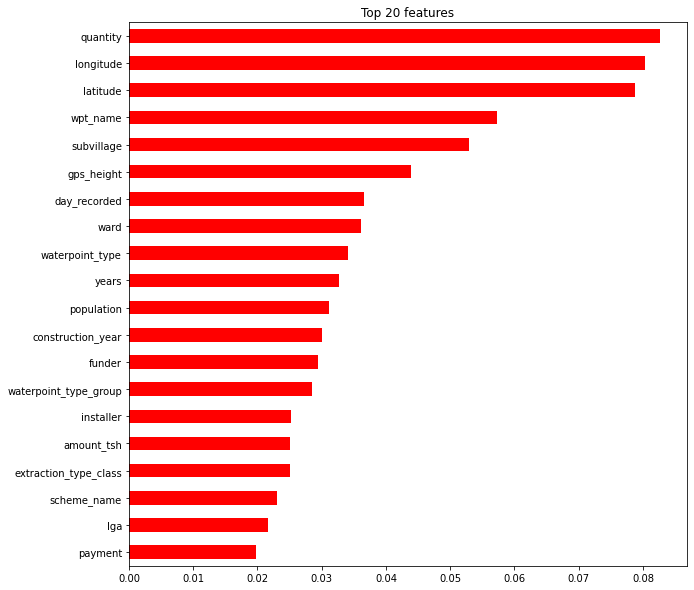

In [8]:
# Get feature importances
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='red');

### 2. Drop-Column Importance

The best in theory, but too slow in practice

In [9]:
column  = 'quantity'

# Fit without column
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)
pipeline.fit(X_train.drop(columns=column), y_train)
score_without = pipeline.score(X_val.drop(columns=column), y_val)
print(f'Validation Accuracy without {column}: {score_without}')

# Fit with column
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)
pipeline.fit(X_train, y_train)
score_with = pipeline.score(X_val, y_val)
print(f'Validation Accuracy with {column}: {score_with}')

# Compare the error with & without column
print(f'Drop-Column Importance for {column}: {score_with - score_without}')

Validation Accuracy without quantity: 0.7771043771043771
Validation Accuracy with quantity: 0.8135521885521886
Drop-Column Importance for quantity: 0.03644781144781151


### 3. Permutation Importance

Permutation Importance is a good compromise between Feature Importance based on impurity reduction (which is the fastest) and Drop Column Importance (which is the "best.")

[The ELI5 library documentation explains,](https://eli5.readthedocs.io/en/latest/blackbox/permutation_importance.html)

> Importance can be measured by looking at how much the score (accuracy, F1, R^2, etc. - any score we’re interested in) decreases when a feature is not available.
>
> To do that one can remove feature from the dataset, re-train the estimator and check the score. But it requires re-training an estimator for each feature, which can be computationally intensive. ...
>
>To avoid re-training the estimator we can remove a feature only from the test part of the dataset, and compute score without using this feature. It doesn’t work as-is, because estimators expect feature to be present. So instead of removing a feature we can replace it with random noise - feature column is still there, but it no longer contains useful information. This method works if noise is drawn from the same distribution as original feature values (as otherwise estimator may fail). The simplest way to get such noise is to shuffle values for a feature, i.e. use other examples’ feature values - this is how permutation importance is computed.
>
>The method is most suitable for computing feature importances when a number of columns (features) is not huge; it can be resource-intensive otherwise.

### Do-It-Yourself way, for intuition

In [10]:
feature = 'quantity'
X_val[feature].head()

3290     insufficient
47666    insufficient
2538           enough
53117          enough
51817          enough
Name: quantity, dtype: object

In [11]:
X_val[feature].value_counts()

enough          6619
insufficient    2976
dry             1325
seasonal         806
unknown          154
Name: quantity, dtype: int64

In [12]:
X_val[feature].value_counts(normalize=True)

enough          0.557155
insufficient    0.250505
dry             0.111532
seasonal        0.067845
unknown         0.012963
Name: quantity, dtype: float64

In [14]:
X_val_permuted = X_val.copy()
# If `x` is a multi-dimensional array, it is only shuffled along its first index.
X_val_permuted[feature] = np.random.permutation(X_val[feature])
X_val_permuted[feature].head()

3290              dry
47666        seasonal
2538     insufficient
53117    insufficient
51817    insufficient
Name: quantity, dtype: object

In [15]:
X_val_permuted[feature].value_counts(normalize=True)

enough          0.557155
insufficient    0.250505
dry             0.111532
seasonal        0.067845
unknown         0.012963
Name: quantity, dtype: float64

*np.random.permutation() only shuffles the value but the value_counts() remain the same*

In [16]:
# Get the permutation importance
# Notice that we don't need to refit here!
score_permuted = pipeline.score(X_val_permuted, y_val)

print(f'Validation Accuracy with {feature}: {score_with}')
print(f'Validation Accuracy with {feature} permuted: {score_permuted}')
print(f'Permutation Importance: {score_with - score_permuted}')

Validation Accuracy with quantity: 0.8135521885521886
Validation Accuracy with quantity permuted: 0.7133838383838383
Permutation Importance: 0.10016835016835024


In [17]:
# Rerun the permutation importance process, 
# but for a different feature
feature = 'wpt_name'
X_val_permuted = X_val.copy()
X_val_permuted[feature] = np.random.permutation(X_val[feature])
score_permuted = pipeline.score(X_val_permuted, y_val)

print(f'Validation Accuracy with {feature}: {score_with}')
print(f'Validation Accuracy with {feature} permuted: {score_permuted}')
print(f'Permutation Importance: {score_with - score_permuted}')

Validation Accuracy with wpt_name: 0.8135521885521886
Validation Accuracy with wpt_name permuted: 0.8104377104377104
Permutation Importance: 0.003114478114478181


### With eli5 library

For more documentation on using this library, see:
- [eli5.sklearn.PermutationImportance](https://eli5.readthedocs.io/en/latest/autodocs/sklearn.html#eli5.sklearn.permutation_importance.PermutationImportance)
- [eli5.show_weights](https://eli5.readthedocs.io/en/latest/autodocs/eli5.html#eli5.show_weights)
- [scikit-learn user guide, `scoring` parameter](https://scikit-learn.org/stable/modules/model_evaluation.html#the-scoring-parameter-defining-model-evaluation-rules)

**eli5 doesn't work with pipelines.**

In [23]:
# Ignore warnings
transformers = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

# unlike .fit(), .fit_transform() returns the transformed input ndarray
X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_transformed, y_train)

(47520, 45) (47520, 45)


RandomForestClassifier(n_jobs=-1, random_state=42)

In [27]:
print(X_train.isna().sum().sum(), pd.DataFrame(X_train_transformed).isna().sum().sum())
print(X_train.shape, X_train_transformed.shape)
pd.DataFrame(X_train_transformed).head()

106143 0
(47520, 45) (47520, 45)


,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
0,0.0,1.0,1167.0,1.0,33.542898,-9.174777,1.0,0.0,1.0,1.0,...,0.0,0.0,1.0,1.0,1.0,2011.0,7.0,27.0,13.0,1.0
1,500.0,2.0,2049.0,2.0,34.665760,-9.308548,2.0,0.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,2011.0,3.0,23.0,3.0,0.0
2,25.0,3.0,290.0,3.0,38.238568,-6.179919,3.0,0.0,3.0,3.0,...,0.0,0.0,0.0,0.0,0.0,2011.0,3.0,7.0,1.0,0.0
3,0.0,4.0,1167.0,4.0,30.716727,-1.289055,4.0,0.0,4.0,4.0,...,0.0,0.0,1.0,1.0,1.0,2011.0,7.0,31.0,13.0,1.0
4,0.0,5.0,1167.0,5.0,35.389331,-6.399942,5.0,0.0,5.0,5.0,...,0.0,0.0,1.0,1.0,1.0,2011.0,3.0,10.0,13.0,1.0


In [28]:
import eli5
from eli5.sklearn import PermutationImportance
"""
cv='prefit': After the fitting
   ``feature_importances_`` attribute becomes available, but the estimator
   itself is not fit again. 
n_iter : int, default 5
    Number of random shuffle iterations. Decrease to improve speed,
    increase to get more precise estimates.
"""


permuter = PermutationImportance(
    model,
    scoring='accuracy',
    cv='prefit',
    n_iter=5,     # Shuffles every features 5 times before averaging its permutation importance
    random_state=42
)

# fitting it with X_train_transformed could yield slightly different results.
permuter.fit(X_val_transformed, y_val)

/Users/shahnam/.pyenv/versions/3.7.8/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/shahnam/.pyenv/versions/3.7.8/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


PermutationImportance(estimator=RandomForestClassifier(n_jobs=-1,
                                                       random_state=42),
                      random_state=42, scoring='accuracy')

In [31]:
feature_names = X_val.columns.tolist()
pd.Series(data=permuter.feature_importances_, index=feature_names).sort_values(ascending=False)
# pd.Series(data=permuter.feature_importances_, index=feature_names).sort_values(ascending=False).plot.barh(color='gray')

quantity                     0.101633
amount_tsh                   0.010758
waterpoint_type              0.010354
extraction_type_class        0.010168
longitude                    0.008838
waterpoint_type_group        0.006751
population                   0.006414
latitude                     0.006246
payment                      0.003064
subvillage                   0.003030
years                        0.002980
public_meeting               0.002963
construction_year            0.002609
district_code                0.002239
extraction_type_group        0.001785
gps_height                   0.001768
source                       0.001549
day_recorded                 0.001498
funder                       0.001128
month_recorded               0.001128
wpt_name                     0.000943
region                       0.000926
region_code                  0.000892
longitude_MISSING            0.000875
scheme_name                  0.000808
permit                       0.000774
lga         

*To show an explanation of estimator parameters (weights) as an IPython.display.HTML object:*

In [32]:
eli5.show_weights(
    permuter,
    top=None,
    feature_names=feature_names
)

Weight,Feature
0.1016 ± 0.0029,quantity
0.0108 ± 0.0024,amount_tsh
0.0104 ± 0.0018,waterpoint_type
0.0102 ± 0.0015,extraction_type_class
0.0088 ± 0.0015,longitude
0.0068 ± 0.0018,waterpoint_type_group
0.0064 ± 0.0008,population
0.0062 ± 0.0026,latitude
0.0031 ± 0.0010,payment
0.0030 ± 0.0015,subvillage


### We can use importances for feature selection

For example, we can remove features with zero importance. The model trains faster and the score does not decrease.

In [33]:
print('Shape before removing features:', X_train.shape)

minimum_importance = 0
# mask is a ndarray with no column label but correct index order
mask = permuter.feature_importances_ > minimum_importance
features = X_train.columns[mask]
X_train_trim = X_train[features]
print('Shape after removing features:', X_train_trim.shape)

Shape before removing features: (47520, 45)
Shape after removing features: (47520, 40)


# Use xgboost for gradient boosting

## Overview

In the Random Forest lesson, you learned this advice:

#### Try Tree Ensembles when you do machine learning with labeled, tabular data
- "Tree Ensembles" means Random Forest or **Gradient Boosting** models. 
- [Tree Ensembles often have the best predictive accuracy](https://arxiv.org/abs/1708.05070) with labeled, tabular data.
- Why? Because trees can fit non-linear, non-[monotonic](https://en.wikipedia.org/wiki/Monotonic_function) relationships, and [interactions](https://christophm.github.io/interpretable-ml-book/interaction.html) between features.
- A single decision tree, grown to unlimited depth, will [overfit](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/). We solve this problem by ensembling trees, with bagging (Random Forest) or **[boosting](https://www.youtube.com/watch?v=GM3CDQfQ4sw)** (Gradient Boosting).
- Random Forest's advantage: may be less sensitive to hyperparameters. **Gradient Boosting's advantage:** may get better predictive accuracy.

Like Random Forest, Gradient Boosting uses ensembles of trees. But the details of the ensembling technique are different:

### Understand the difference between boosting & bagging

Boosting (used by Gradient Boosting) is different than Bagging (used by Random Forests). 

Here's an excerpt from [_An Introduction to Statistical Learning_](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf) Chapter 8.2.3, Boosting:

>Recall that bagging involves creating multiple copies of the original training data set using the bootstrap, fitting a separate decision tree to each copy, and then combining all of the trees in order to create a single predictive model.
>
>**Boosting works in a similar way, except that the trees are grown _sequentially_: each tree is grown using information from previously grown trees.**
>
>Unlike fitting a single large decision tree to the data, which amounts to _fitting the data hard_ and potentially overfitting, the boosting approach instead _learns slowly._ Given the current model, we fit a decision tree to the residuals from the model.
>
>We then add this new decision tree into the fitted function in order to update the residuals. Each of these trees can be rather small, with just a few terminal nodes. **By fitting small trees to the residuals, we slowly improve fˆ in areas where it does not perform well.**
>
>Note that in boosting, unlike in bagging, the construction of each tree depends strongly on the trees that have already been grown.

This high-level overview is all you need to know for now. If you want to go deeper, we recommend you watch the StatQuest videos on gradient boosting!

Let's write some code. We have lots of options for which libraries to use:

#### Python libraries for Gradient Boosting
- [scikit-learn Gradient Tree Boosting](https://scikit-learn.org/stable/modules/ensemble.html#gradient-boosting) — slower than other libraries, but [the new version may be better](https://twitter.com/amuellerml/status/1129443826945396737)
  - Anaconda: already installed
  - Google Colab: already installed
- [xgboost](https://xgboost.readthedocs.io/en/latest/) — can accept missing values and enforce [monotonic constraints](https://xiaoxiaowang87.github.io/monotonicity_constraint/)
  - Anaconda, Mac/Linux: `conda install -c conda-forge xgboost`
  - Windows: `conda install -c anaconda py-xgboost`
  - Google Colab: already installed
- [LightGBM](https://lightgbm.readthedocs.io/en/latest/) — can accept missing values and enforce [monotonic constraints](https://blog.datadive.net/monotonicity-constraints-in-machine-learning/)
  - Anaconda: `conda install -c conda-forge lightgbm`
  - Google Colab: already installed
- [CatBoost](https://catboost.ai/) — can accept missing values and use [categorical features](https://catboost.ai/docs/concepts/algorithm-main-stages_cat-to-numberic.html) without preprocessing
  - Anaconda: `conda install -c conda-forge catboost`
  - Google Colab: `pip install catboost`

In this lesson, you'll use a new library, xgboost — But it has an API that's almost the same as scikit-learn, so it won't be a hard adjustment!

#### [XGBoost Python API Reference: Scikit-Learn API](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn)

In [40]:
from xgboost import XGBClassifier

# xgboost does not need imputer
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

pipeline.fit(X_train, y_train)

/Users/shahnam/.pyenv/versions/3.7.8/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:07:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['funder', 'installer', 'wpt_name',
                                      'basin', 'subvillage', 'region', 'lga',
                                      'ward', 'public_meeting',
                                      'scheme_management', 'scheme_name',
                                      'permit', 'extraction_type',
                                      'extraction_type_group',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'water_quality', 'quality_group',
                                      'quantity', 'source',...
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan

In [41]:
from sklearn.metrics import accuracy_score
y_pred = pipeline.predict(X_val)
print('Validation Accuracy', accuracy_score(y_val, y_pred))

Validation Accuracy 0.8026094276094277


#### [Avoid Overfitting By Early Stopping With XGBoost In Python](https://machinelearningmastery.com/avoid-overfitting-by-early-stopping-with-xgboost-in-python/)

Why is early stopping better than a For loop, or GridSearchCV, to optimize `n_estimators` in boosting ensembeled trees?

With early stopping, if `n_iterations` is our number of iterations, then we fit `n_iterations` decision trees.

With a for loop, or GridSearchCV, we'd fit `sum(range(1,n_rounds+1))` trees, as boosting is a series operation and requires everytime to start from one tree and goes up

**But it doesn't work well with pipelines.** You may need to re-run multiple times with different values of other parameters such as `max_depth` and `learning_rate`.

#### XGBoost parameters
- [Notes on parameter tuning](https://xgboost.readthedocs.io/en/latest/tutorials/param_tuning.html)
- [Parameters documentation](https://xgboost.readthedocs.io/en/latest/parameter.html)


### Tree Ensemble Boosting:
RandomForest works based on bagging the input data by sampling the rows of input data randomly with/out replacement. Hence all the estimator trees can be trained at the same time. 

Gradient boost develops the trees sequentioally. It starts with the base model. Let's call the base_model_prediction (such as mean of all $y_{truth}$) as first estimate, $h_0$. Then create 1st Residual from that, by let's say $R_0=y_{true} - h_0$. Next, train the 1st tree for the residual label, $R_0$, as a target label. The predicted output of the first tree is an estimate of $R_0$, named $R0$. Adding predicted residual $R0$ to $h_0$ would come very close to the $y_{true}$. However, we don't want to take a big step, as it would introduce big variance despite offering small bias. Hence we multiply the predicted psudo residual $R0$ with learning rate $0<\alpha<1$ to bring the the y prediction one step closer to the $y_{true}$. The new target prediction is $h_1 = h_0 + \alpha \times R0$. Now we can calculate the new psudo residual $R_1$ and then train a subsequent shallow tree for that, $R_1 = y_{true} - h_1$. Normally, $R_1$ is smaller residual than $R_0$ as we take small steps towards $y_{truth}$. This is because we added a portion of the predicted previouse residual to our previous total prediction and improved the new total prediction. Let's name the estimated $R_1$ as $R1$. Now the new improved target prediction is $h_2 = h_1 + \alpha \times R1 = h_0 + \alpha \times R0 + \alpha \times R1$. We continue this process till we statisfy loss function criteria.

In a nutshell we start with a base model and derive the psudo residual. Then train a shallow tree to predict that residual and add a fraction of that tree's predicted residual label as its contribution to the base model to improve our y prediction. Next calculate the newly improved residual based on the $y_{true}$ and the previous total prediction. The second tree would try to predict the new residual and add a fractional contribution (learning rate) to the previousely overall prediction. By training sequential trees to predict every newly improved residual and improving the overal prediction by small steps controlled by learning rate we get closer to the $y_{true}$. Once again need to emphasize that every new residual is calculated based on $y_{true}$ - **overall** prediction calculated in its previous step.

In [42]:
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

model = XGBClassifier(
    n_estimators = 1000,
    max_depth=7,
    learning_rate=0.5,
    n_jobs=-1
)

eval_set = [(X_train_encoded, y_train), 
            (X_val_encoded, y_val)]

"""
merror: Multiclass classification error rate. 
It is calculated as #(wrong cases)/#(all cases).
"""
model.fit(X_train_encoded, y_train, 
          eval_set=eval_set, 
          eval_metric='merror', 
          early_stopping_rounds=10) # Stop if the score hasn't improved in 10 rounds

[0]	validation_0-merror:0.24956	validation_1-merror:0.25800
[1]	validation_0-merror:0.23944	validation_1-merror:0.25050
[2]	validation_0-merror:0.23163	validation_1-merror:0.24268
[3]	validation_0-merror:0.22525	validation_1-merror:0.23763
[4]	validation_0-merror:0.21871	validation_1-merror:0.23451
[5]	validation_0-merror:0.21212	validation_1-merror:0.23014
[6]	validation_0-merror:0.20572	validation_1-merror:0.22660
[7]	validation_0-merror:0.19844	validation_1-merror:0.22298
[8]	validation_0-merror:0.19512	validation_1-merror:0.22222
[9]	validation_0-merror:0.19226	validation_1-merror:0.22087
[10]	validation_0-merror:0.18872	validation_1-merror:0.21785
[11]	validation_0-merror:0.18468	validation_1-merror:0.21406
[12]	validation_0-merror:0.18039	validation_1-merror:0.21195
[13]	validation_0-merror:0.17837	validation_1-merror:0.21212
[14]	validation_0-merror:0.17572	validation_1-merror:0.21052
[15]	validation_0-merror:0.17323	validation_1-merror:0.21254
[16]	validation_0-merror:0.16955	v

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.5, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [43]:
model.best_iteration

36

### Try adjusting these hyperparameters

#### Random Forest
- class_weight (for imbalanced classes)
- max_depth (usually high, can try decreasing)
- n_estimators (too low underfits, too high wastes time)
- min_samples_leaf (increase if overfitting)
- max_features (decrease for more diverse trees)

#### Xgboost
- scale_pos_weight (for imbalanced classes)
- max_depth (usually low, can try increasing)
- n_estimators (too low underfits, too high wastes time/overfits) — Use Early Stopping!
- learning_rate (too low underfits, too high overfits)

For more ideas, see [Notes on Parameter Tuning](https://xgboost.readthedocs.io/en/latest/tutorials/param_tuning.html) and [DART booster](https://xgboost.readthedocs.io/en/latest/tutorials/dart.html).

## Challenge

You will use your portfolio project dataset for all assignments this sprint. Complete these tasks for your project, and document your work.

- Continue to clean and explore your data. Make exploratory visualizations.
- Fit a model. Does it beat your baseline?
- Try xgboost.
- Get your model's permutation importances.

You should try to complete an initial model today, because the rest of the week, we're making model interpretation visualizations.

But, if you aren't ready to try xgboost and permutation importances with your dataset today, you can practice with another dataset instead. You may choose any dataset you've worked with previously.